In [119]:
import sys
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/Colab Notebooks/deeplearning_note')

Mounted at /content/drive


In [120]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestRegressor



In [121]:
def evaluate_performance(all_target, predicted, toplot=True,silent=True):
    all_target = np.array(all_target)
    predicted = np.array(predicted)
    fpr, tpr, thresholds = roc_curve(all_target, predicted)
    roc_auc = auc(fpr, tpr)
    ks = max(tpr-fpr)
    maxind = (tpr-fpr).argmax()

    event_rate = sum(all_target) / 1.0 / all_target.shape[0]
    cum_total = tpr * event_rate + fpr * (1-event_rate)
    minind, = np.nonzero(np.ravel(abs(cum_total - event_rate) == min(abs(cum_total - event_rate))))
    if minind.shape[0] > 0:
        minind = minind[0]

    if toplot:
        # KS plot
        plt.figure(figsize=(26,6))
        plt.subplot(1,4,1)
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1], color='k', linestyle='--', linewidth=2)
        plt.title('KS='+str(round(ks,3))+ ' AUC='+str(round(roc_auc,3)), fontsize=20)
        plt.plot([fpr[maxind], fpr[maxind]], [fpr[maxind], tpr[maxind]], linewidth=4, color='r')
        plt.plot([fpr[minind]], [tpr[minind]], 'k.', markersize=10)

        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xlabel('False positive', fontsize=20); plt.ylabel('True positive', fontsize=20);
        if not silent:
            print ('KS=' + str(round(ks,3)) + ', AUC=' + str(round(roc_auc,3)) +', N='+str(predicted.shape[0]))
            print ('At threshold=' + str(round(event_rate, 3)) + ', TPR=' + str(round(tpr[minind],3)) + ', ' + str(int(round(tpr[minind]*event_rate*all_target.shape[0]))) + ' out of ' + str(int(round(event_rate*all_target.shape[0]))) ) 
            print ('At threshold=' + str(round(event_rate, 3)) + ', TPR=' + str(round(fpr[minind],3)) + ', ' + str(int(round(fpr[minind]*(1.0-event_rate)*all_target.shape[0]))) + ' out of ' + str(int(round((1.0-event_rate)*all_target.shape[0]))))  
    
        # Score distribution score
        plt.subplot(1,4,2)
        #print predicted.columns
        plt.hist(predicted, bins=20)
        plt.axvline(x=np.mean(predicted), linestyle='--')
        plt.axvline(x=np.mean(all_target), linestyle='--', color='g')
        plt.title('N='+str(all_target.shape[0])+' Tru='+str(round(np.mean(all_target),3))+' Pred='+str(round(np.mean(predicted),3)), fontsize=20)
        plt.xlabel('Target rate', fontsize=20)
        plt.ylabel('Count', fontsize=20)

        # Score average by percentile
        binnum = 10
        ave_predict = np.zeros((binnum))
        ave_target = np.zeros((binnum))
        indices = np.argsort(predicted)
        binsize = int(round(predicted.shape[0]/1.0/binnum))
        for i in range(binnum):
            startind = i*binsize
            endind = min(predicted.shape[0], (i+1)*binsize)
            ave_predict[i] = np.mean(predicted[indices[startind:endind]])
            ave_target[i] = np.mean(all_target[indices[startind:endind]])
        
        plt.subplot(1,4,3)
        plt.plot(ave_predict, 'b.-', label='Prediction', markersize=5)
        plt.plot(ave_target, 'r.-', label='Truth', markersize=5)
        plt.legend(loc='lower right')
        plt.xlabel('Percentile', fontsize=20)
        plt.ylabel('Target rate', fontsize=20)
        plt.title("Sloping", fontsize=20)
        if not silent:
            print ('Ave_target: ' + str([round(i,4) for i in ave_target]))
            print ('Ave_predicted: ' + str(ave_predict))
            
            
        count_predict = np.zeros((binnum+1))
        count_target = np.zeros((binnum+1))
        indices = np.argsort(predicted,)
        binsize = int(round(predicted.shape[0]/1.0/binnum))
        for i in range(binnum+1):
            endind = min(predicted.shape[0], (i)*binsize)
            count_predict[i] = np.sum(all_target)-np.sum(all_target[indices[0:endind]])
            count_target[i] = np.sum(all_target)
        
        count_predict = list(count_predict)
        count_predict.reverse()
        ave_predict = list((count_predict/count_target))

        top_20_len = int(len(predicted)/5)
        top_20_ratio = np.sum(all_target[indices[-top_20_len:]])*100.0/np.sum(all_target)
        
        btm_10_len = int(len(predicted)/10)
        btm_10_ratio = np.sum(all_target[indices[:btm_10_len]])*100.0/np.sum(all_target)
        
        plt.subplot(1,4,4)
        plt.plot(ave_predict, 'b.-', markersize=5)
        plt.legend(loc='up right')
        plt.xlabel('Top score bin(bad-->good)', fontsize=20)
        plt.ylabel('Capture rate', fontsize=20)
        plt.title("TOP20:{0}% , BTM10:{1}%".format(round(top_20_ratio,2),round(btm_10_ratio,2)), fontsize=20)
        if not silent:
            print ('#True: ' + str([int(i) for i in count_predict]))
            print ('%True: ' + str([round(i,2) for i in ave_predict]))            
            
        
        plt.show()

    return ks

## LR classification

In [122]:
train_data = pd.read_csv("https://raw.githubusercontent.com/PANDASANG1231/522_Ramen/main/data/process/train_process.csv")
test_data = pd.read_csv("https://raw.githubusercontent.com/PANDASANG1231/522_Ramen/main/data/process/test_process.csv")

print(train_data.shape, test_data.shape)


## Preprocess the target
def handle_target(x, thresh=3.5):
    
    if x < thresh:
        return 1
    else:
        return 0
    
train_data["Stars"] = train_data["Stars"].replace("Unrated", -1).astype(float).apply(handle_target)
test_data["Stars"] = test_data["Stars"].replace("Unrated", -1).astype(float).apply(handle_target)


list_feature = [x for x in train_data if x != "Stars"]

# ## Process categorical variables
# list_feature = ['Brand', 'Variety', 'Style','code']
# lst_var_cat = ['Brand', 'Variety', 'Style','code']

# mapping_dict = preprocess_categorical(train_data, lst_var_cat, tail_count=20)

# for key in mapping_dict:
#     train_data[key] = train_data[key].map(mapping_dict[key])
#     test_data[key] = test_data[key].map(mapping_dict[key])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (370) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2064, 371) (516, 371)


In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, make_pipeline


X_train, y_train = train_data[list_feature], train_data["Stars"]
X_test, y_test = test_data[list_feature], test_data["Stars"]

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)





In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, make_pipeline


X_train, y_train = train_data[list_feature], train_data["Stars"]
X_test, y_test = test_data[list_feature], test_data["Stars"]

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Unrecognized location 'up right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


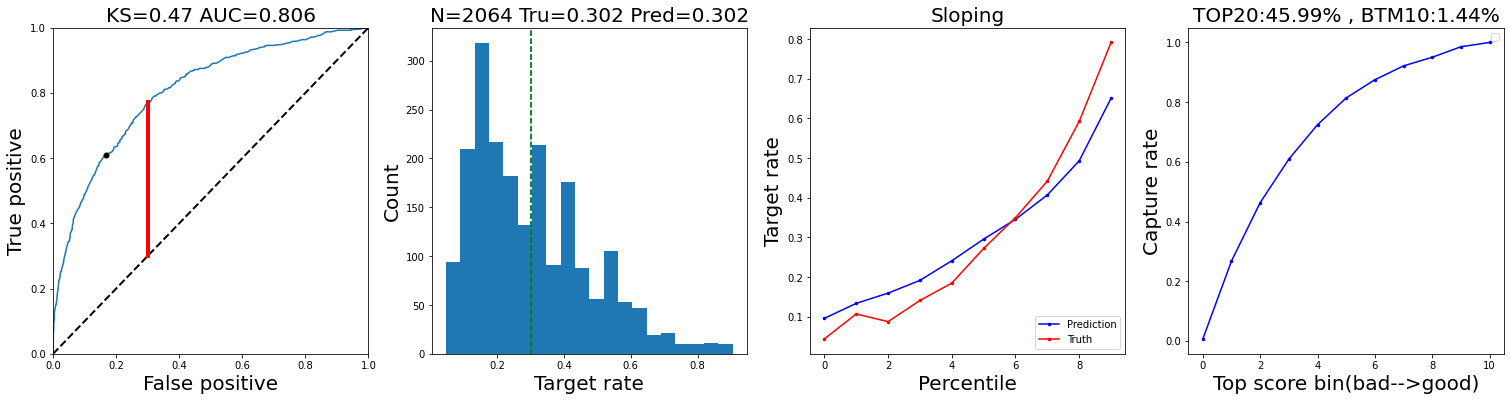

No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Unrecognized location 'up right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


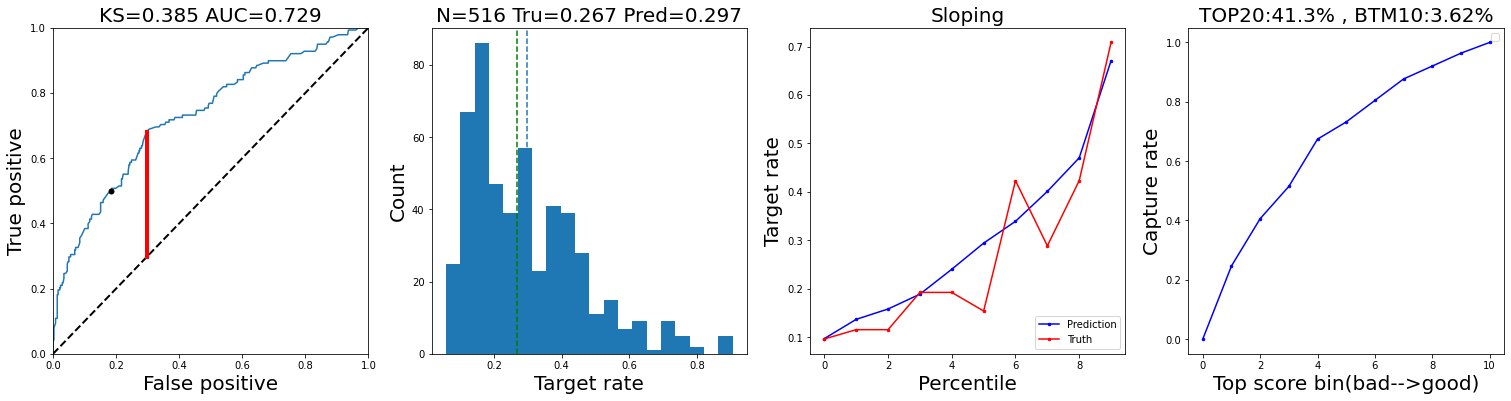

0.3848631239935588

In [125]:
model_lr = LogisticRegression()

# mean_std_cross_val_scores(model_lr, X_train, y_train, scoring="roc_auc")
model_lr.fit(X_train, y_train)

y_prediction = model_lr.predict_proba(X_test)


evaluate_performance(y_train, model_lr.predict_proba(X_train)[:, 1])

evaluate_performance(y_test, model_lr.predict_proba(X_test)[:, 1])


## LR Regression


In [126]:
print("Number of Features remain: ", len(model_lr.feature_names_in_))

Number of Features remain:  370


In [127]:
train_data

,onehotencoder__Brand_1 To 3 Noodles,onehotencoder__Brand_7 Select,onehotencoder__Brand_7 Select/Nissin,onehotencoder__Brand_A-One,onehotencoder__Brand_A-Sha Dry Noodle,onehotencoder__Brand_A1,onehotencoder__Brand_ABC,onehotencoder__Brand_Acecook,onehotencoder__Brand_Adabi,onehotencoder__Brand_Ah Lai,onehotencoder__Brand_Ajinatori,onehotencoder__Brand_Amianda,onehotencoder__Brand_Amino,onehotencoder__Brand_Annie Chun's,onehotencoder__Brand_Aroi,onehotencoder__Brand_Asia Gold,onehotencoder__Brand_Asian Thai Foods,onehotencoder__Brand_Authentically Asian,onehotencoder__Brand_Azami,onehotencoder__Brand_Baijia,onehotencoder__Brand_Baixiang Noodles,onehotencoder__Brand_Baltix,onehotencoder__Brand_Bamee,onehotencoder__Brand_Batchelors,onehotencoder__Brand_Binh Tay,onehotencoder__Brand_Bon Go Jang,onehotencoder__Brand_Bonasia,onehotencoder__Brand_Boss,onehotencoder__Brand_CJ CheilJedang,onehotencoder__Brand_Campbell's,onehotencoder__Brand_Cap Atoom Bulan,onehotencoder__Brand_CarJEN,onehotencoder__Brand_Chencun,onehotencoder__Brand_Chering Chang,onehotencoder__Brand_Chewy,onehotencoder__Brand_Chikara,onehotencoder__Brand_Ching's Secret,onehotencoder__Brand_Chorip Dong,onehotencoder__Brand_ChoripDong,onehotencoder__Brand_Choumama,...,onehotencoder__Style_nan,onehotencoder__Country_Australia,onehotencoder__Country_Bangladesh,onehotencoder__Country_Brazil,onehotencoder__Country_Cambodia,onehotencoder__Country_Canada,onehotencoder__Country_China,onehotencoder__Country_Colombia,onehotencoder__Country_Dubai,onehotencoder__Country_Estonia,onehotencoder__Country_Fiji,onehotencoder__Country_Finland,onehotencoder__Country_Germany,onehotencoder__Country_Ghana,onehotencoder__Country_Holland,onehotencoder__Country_Hong Kong,onehotencoder__Country_Hungary,onehotencoder__Country_India,onehotencoder__Country_Indonesia,onehotencoder__Country_Japan,onehotencoder__Country_Malaysia,onehotencoder__Country_Mexico,onehotencoder__Country_Myanmar,onehotencoder__Country_Nepal,onehotencoder__Country_Netherlands,onehotencoder__Country_Nigeria,onehotencoder__Country_Pakistan,onehotencoder__Country_Philippines,onehotencoder__Country_Poland,onehotencoder__Country_Sarawak,onehotencoder__Country_Singapore,onehotencoder__Country_South Korea,onehotencoder__Country_Sweden,onehotencoder__Country_Taiwan,onehotencoder__Country_Thailand,onehotencoder__Country_UK,onehotencoder__Country_USA,onehotencoder__Country_United States,onehotencoder__Country_Vietnam,Stars
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,

In [128]:
train_data = pd.read_csv("https://raw.githubusercontent.com/PANDASANG1231/522_Ramen/main/data/process/train_process.csv")
test_data = pd.read_csv("https://raw.githubusercontent.com/PANDASANG1231/522_Ramen/main/data/process/test_process.csv")

train_data["Stars"] = train_data["Stars"].replace("Unrated", -1).astype(float)
test_data["Stars"] = test_data["Stars"].replace("Unrated", -1).astype(float)

X_train, y_train = train_data.drop(columns="Stars"), train_data["Stars"]
X_test, y_test = test_data.drop(columns="Stars"), test_data["Stars"]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (370) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [129]:
# model_lr.fit(X_train, y_train)

# y_prediction = model_lr.predict_proba(X_test)


# evaluate_performance(y_train, model_lr.predict_proba(X_train)[:, 1])

# evaluate_performance(y_test, model_lr.predict_proba(X_test)[:, 1])

models = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
}

score_types_reg = {
    "neg_mean_squared_error": "neg_mean_squared_error",
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "r2": "r2",
}

ridg = models["Ridge"]
ridg_score = pd.DataFrame(cross_validate(ridg, X_train, y_train, cv=5, scoring=score_types_reg, return_train_score=True)).mean()

rf = models["Random Forest"]
rf_score = pd.DataFrame(cross_validate(rf, X_train, y_train, cv=5, scoring=score_types_reg, return_train_score=True)).mean()


results = pd.concat((ridg_score, rf_score), axis=1)
results.columns = ["ridge", "rf"]
results

,ridge,rf
fit_time,0.046845,3.260883
score_time,0.013612,0.026184
test_neg_mean_squared_error,-0.883907,-0.933201
train_neg_mean_squared_error,-0.628018,-0.513681
test_neg_root_mean_squared_error,-0.938278,-0.964264
train_neg_root_mean_squared_error,-0.792383,-0.716647
test_neg_mean_absolute_error,-0.687254,-0.698133
train_neg_mean_absolute_error,-0.583427,-0.521872
test_r2,0.168984,0.119152
train_r2,0.411002,0.518063


In [130]:
ridg.fit(X_train, y_train)
y_prediction_ridge = ridg.predict(X_test)

rf.fit(X_train, y_train)
y_prediction_rf = rf.predict(X_test)


In [131]:
test_result = test_data[["Stars"]]

test_result["y_prediction_ridge"] = y_prediction_ridge
test_result["y_prediction_rf"] = y_prediction_rf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
